In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Data 

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"
basis = "6-311++g**"

data = Data()
data.include(data_path = "../../thesis/dataset/EthanT/", postfix = "EthanT", target=target)

In [4]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

species = "C"

dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2


# Descriptor

In [5]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    SphereSectionDescriptor, ConstantAngularDescriptor, Gaussians
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(8, R_c=3.5, R_min=1.0, eta_max=100)#, eta_min=80)

radial = Gaussians(*model)

descriptor = AtomicNumberWeighted(
    ConstantAngularDescriptor(),
    SphereSectionDescriptor(
        number_azimuthal_sections=8,
        number_polar_sections=4,
        radial_descriptor=radial
    ),
    BehlerCutoff1(5)
)
    

# Calculate Dataset 

In [6]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset

dataset = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C"
)

(
    dataset.testing[0][0].shape, 
    len(dataset.training[1]), 
    len(dataset.validation[1]),
    len(dataset.testing[1])
)

((256,), 1280, 320, 402)

# Normalize Output


In [7]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

y = np.array(list(dataset.training[1]) + \
        list(dataset.validation[1]) + \
            list(dataset.testing[1]))

print(y.shape)

y_norm, _, _ = AbstractDataset.normalize(y)

y_norm.shape, np.max(np.mean(y_norm, 0)), np.max(np.std(y_norm, 0))

(2002, 253)


((2002, 253), 2.4338839302282002e-14, 1.000000000000002)

# Heatmap 

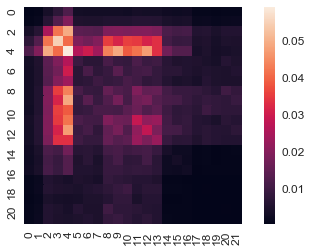

In [13]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu_batch


sns.heatmap(np.std(reconstruct_from_triu_batch(y, dim), 0), square=True)

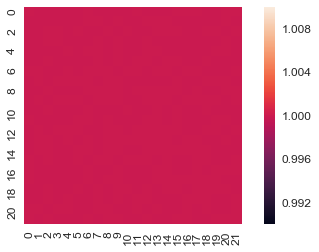

In [23]:
sns.heatmap(np.std(reconstruct_from_triu_batch(y_norm, dim), 0), square=True, vmin=0.99, vmax=1.01)

# Covariance 

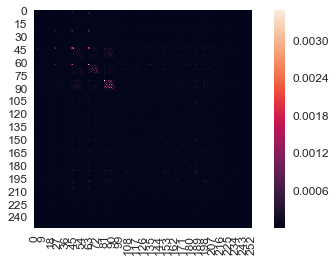

In [26]:
sns.heatmap(np.abs(np.cov(y.transpose())), square=True)

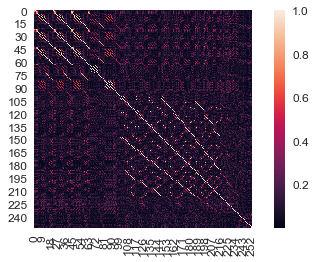

In [19]:
sns.heatmap(np.abs(np.cov(y_norm.transpose())), square=True)

# Time Evolution 

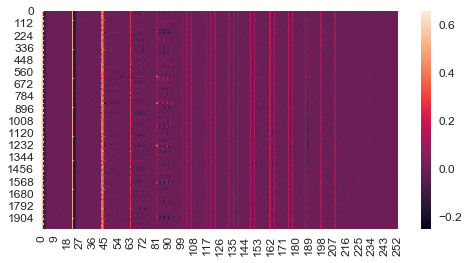

In [20]:
sns.heatmap(y)

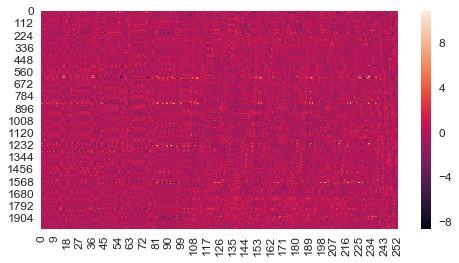

In [21]:
sns.heatmap(y_norm)